# Import libs

In [4]:
import os
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import OxfordIIITPet
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchmetrics
from torch.utils.data import DataLoader, Subset
from torch.nn import functional as F
import clip
import json
import numpy as np
from tqdm import tqdm

# Load Dataset using the Mean and std dev of training dataset

In [5]:
oxfordpet_path = '/home/kush/Desktop/CLIP/'
transform = transforms.Compose([
    transforms.Resize(224, interpolation=Image.BICUBIC),
    transforms.CenterCrop(224),
    lambda image: image.convert("RGB"),
    transforms.ToTensor(),
    transforms.Normalize((0.4827, 0.4472, 0.3974), (0.2289, 0.2260, 0.2275)),
])
oxfordpet_dataset_train = OxfordIIITPet(oxfordpet_path, split="trainval", transform = transform)
oxfordpet_dataset_test = OxfordIIITPet(oxfordpet_path, split="test", transform = transform)

In [3]:
oxfordpet_dataset_train.classes

NameError: name 'class_' is not defined

# Change Class names -> They are not proper

In [ ]:
def get_full_class_labels(file_path):
    classes_full_names = set()
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            class_id, _, species, _ = line.strip('\n').split(' ', 3)
            class_id = ' '.join(class_id.split('_')[0: -1]).title()
            if int(species) == 1:
                class_id += ' Cat'
            else:
                class_id += ' Dog'
            classes_full_names.add(class_id)
    return classes_full_names

In [5]:
def fix_class_names(dataset, complete_class_names):
    for class_name in complete_class_names:
        incomplete_class_name = ' '.join(class_name.split(' ')[0: -1]).strip()
        find_index = lambda l, x: l.index(x) if x in l else -1
        index_of_incorrect_class = find_index(dataset.classes, incomplete_class_name)
        if index_of_incorrect_class != -1:
            dataset.classes[index_of_incorrect_class] = class_name
        idx = dataset.class_to_idx.pop(incomplete_class_name, -1)
        if idx != -1:
            dataset.class_to_idx[class_name] = idx

In [6]:
list_txt_path = '/home/kush/Desktop/CLIP/oxford-iiit-pet/annotations/list.txt'
full_class_labels = get_full_class_labels(list_txt_path)
fix_class_names(oxfordpet_dataset_train, full_class_labels)
fix_class_names(oxfordpet_dataset_test, full_class_labels)
print(oxfordpet_dataset_train.classes)
print(oxfordpet_dataset_train.class_to_idx)

['Abyssinian Cat', 'American Bulldog Dog', 'American Pit Bull Terrier Dog', 'Basset Hound Dog', 'Beagle Dog', 'Bengal Cat', 'Birman Cat', 'Bombay Cat', 'Boxer Dog', 'British Shorthair Cat', 'Chihuahua Dog', 'Egyptian Mau Cat', 'English Cocker Spaniel Dog', 'English Setter Dog', 'German Shorthaired Dog', 'Great Pyrenees Dog', 'Havanese Dog', 'Japanese Chin Dog', 'Keeshond Dog', 'Leonberger Dog', 'Maine Coon Cat', 'Miniature Pinscher Dog', 'Newfoundland Dog', 'Persian Cat', 'Pomeranian Dog', 'Pug Dog', 'Ragdoll Cat', 'Russian Blue Cat', 'Saint Bernard Dog', 'Samoyed Dog', 'Scottish Terrier Dog', 'Shiba Inu Dog', 'Siamese Cat', 'Sphynx Cat', 'Staffordshire Bull Terrier Dog', 'Wheaten Terrier Dog', 'Yorkshire Terrier Dog']
{'Egyptian Mau Cat': 11, 'Basset Hound Dog': 3, 'Leonberger Dog': 19, 'Keeshond Dog': 18, 'Great Pyrenees Dog': 15, 'Japanese Chin Dog': 17, 'Bengal Cat': 5, 'Beagle Dog': 4, 'Havanese Dog': 16, 'Newfoundland Dog': 22, 'Ragdoll Cat': 26, 'Persian Cat': 23, 'Samoyed Dog':

# Calc mean and std dev from training DS

In [7]:
# mean = torch.zeros(3)
# std_dev = torch.zeros(3)

# for img, _ in oxfordpet_dataset:
#     mean += img.mean(dim=(1, 2))
#     std_dev += img.std(dim=(1, 2))
# mean /= len(oxfordpet_dataset)
# std_dev /= len(oxfordpet_dataset)
# print("Mean values:", mean)
# print("Std Dev values:", std_dev)

# Load model

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device, jit=False)
model = model.eval()
model = model.requires_grad_(False)

# Function for computing Label text emebddings

In [9]:
def compute_encodings(model, labels):
    label_encodings = F.normalize(model.encode_text(clip.tokenize(labels).to(device)))
    return label_encodings

# Function for index to label

In [10]:
def idx_to_label(label_to_idx):
    dataset_items = list(label_to_idx.items())
    return dict(map(lambda x: x[::-1], dataset_items))

In [11]:
def initialize_counter_dict(labels):
    dict_ = dict()
    for label1 in labels:
        dict_[label1] = dict()
        for label2 in labels:
            dict_[label1][label2] = 0
    return dict_

In [12]:
def increase_count(counter_dict, actual_class, top_classes):
    for class_ in top_classes:
        counter_dict[actual_class][class_] += 1
    return counter_dict

In [13]:
def add_to_counter_dict(counter_dict, index_to_class_dict, actual_index_list, 
                        pred_index_list):
    for idx, actual_class_index in enumerate(actual_index_list):
        actual_class = index_to_class_dict[int(actual_class_index)]
        top_classes = list(map(lambda x: index_to_class_dict[int(x)], 
                               pred_index_list[idx].squeeze()))
        counter_dict = increase_count(counter_dict, actual_class, top_classes)
    return counter_dict

# Calculate CLIP accuracy

In [16]:
def calc_acc(model, dataset, descriptions, batch_size = 64*10, count_classes = False, 
             topK = 5):
    
    count_classes_dict = initialize_counter_dict(dataset.classes)
    index_to_class_dict = idx_to_label(dataset.class_to_idx)
    
    
    encodings = compute_encodings(model, descriptions)
    clip_accuracy_metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(dataset.classes)).to(device)
    clip_accuracy_metric_top5 = torchmetrics.Accuracy(top_k=5, task="multiclass", num_classes=len(dataset.classes)).to(device)
    dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=16, pin_memory=True)
    for batch_number, batch in enumerate(tqdm(dataloader)):
        images, labels = batch

        images = images.to(device)
        labels = labels.to(device)

        image_encodings = model.encode_image(images)
        image_encodings = F.normalize(image_encodings)

        image_labels_similarity = image_encodings @ encodings.T
        top5_values, top5_indices = image_labels_similarity.topk(5, dim=1)
        clip_predictions = image_labels_similarity.argmax(dim=1)


        clip_acc = clip_accuracy_metric(image_labels_similarity, labels)
        clip_acc_top5 = clip_accuracy_metric_top5(image_labels_similarity, labels)
        
        
        if count_classes == True:
            count_classes_dict = add_to_counter_dict(count_classes_dict, index_to_class_dict,
                                                 labels, top5_indices)


    accuracy_logs = {}
    accuracy_logs["Total CLIP-Standard Top-1 Accuracy: "] = 100*clip_accuracy_metric.compute().item()
    accuracy_logs["Total CLIP-Standard Top-5 Accuracy: "] = 100*clip_accuracy_metric_top5.compute().item()
    
    if count_classes == True:
        for actual_key in count_classes_dict.keys():
            count_classes_dict[actual_key] = sorted(count_classes_dict[actual_key].items(),
                                                key=lambda x: x[1], reverse=True)

        json_string = json.dumps(count_classes_dict, indent=4)  # indent for pretty formatting

        # Write JSON string to a text file
        with open(f'top{topK}.txt', 'w') as file:
            file.write(json_string)

    
    return accuracy_logs

In [32]:
calc_acc(model, oxfordpet_dataset_train, oxfordpet_dataset_train.classes,
         count_classes = True)

100%|█████████████████████████████████████████████| 6/6 [00:12<00:00,  2.15s/it]


{'Total CLIP-Standard Top-1 Accuracy: ': 86.3858699798584,
 'Total CLIP-Standard Top-5 Accuracy: ': 99.32065010070801}

# Graphs

In [33]:
def create_graph(actual_label, top5_pred):
    top5labels = list(map(lambda x: x[0], top5_pred))
    top5counts = list(map(lambda x: x[1], top5_pred))
    colors = ['royalblue' if label == actual_label else 'lightsteelblue' for label in top5labels]
    plt.barh(top5labels, top5counts, color=colors)

    num_ticks = 6  # Adjust the number of ticks as needed
    tick_positions = np.linspace(0, max(top5counts), num_ticks)
    plt.xticks(tick_positions, rotation=45, ha='right')  # Set the rotation and horizontal alignment

    plt.xlabel('Top-5 counts')
    plt.ylabel('Classes')
    plt.title('Score-wise Diagram')
    
    # Show the plot
    plt.show()


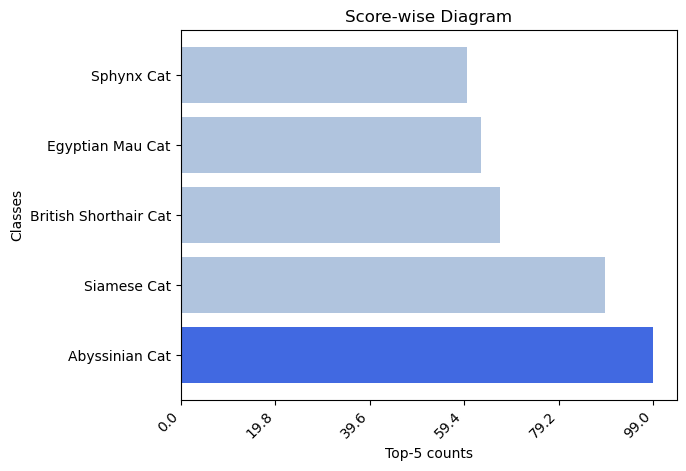

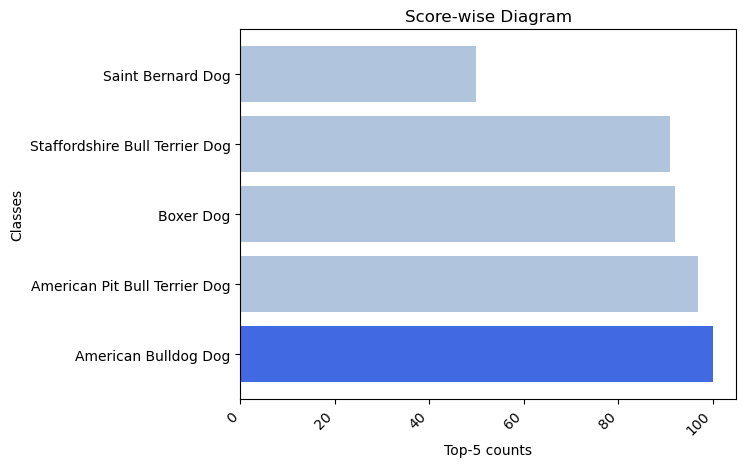

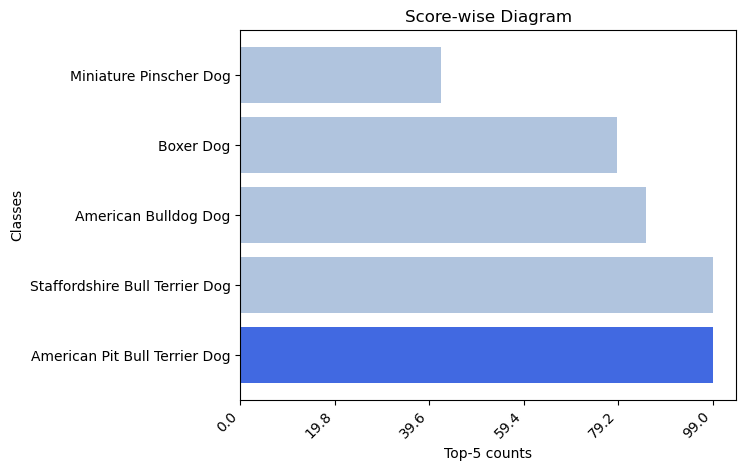

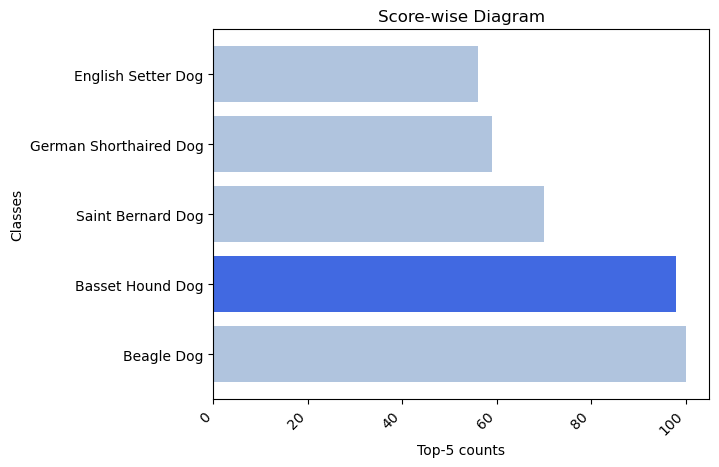

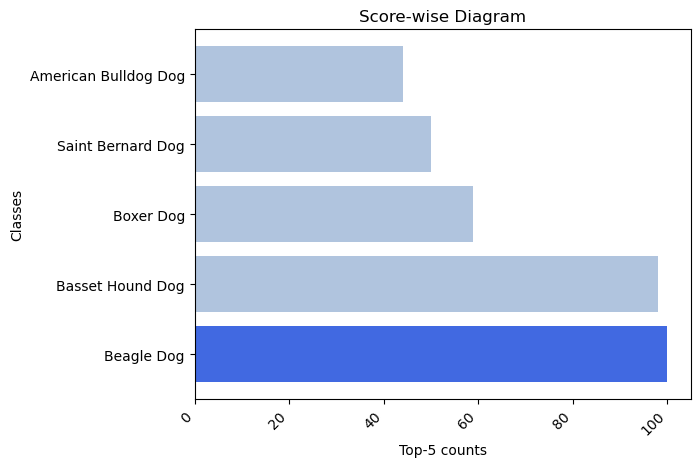

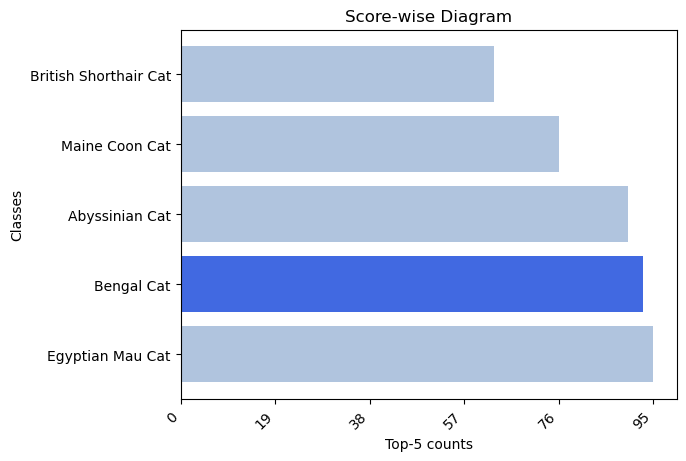

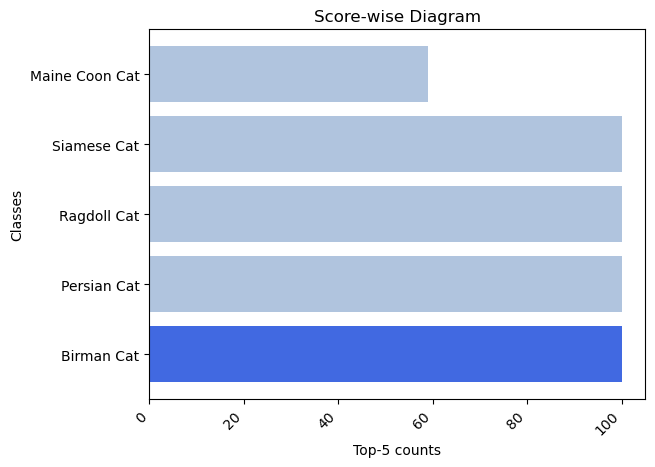

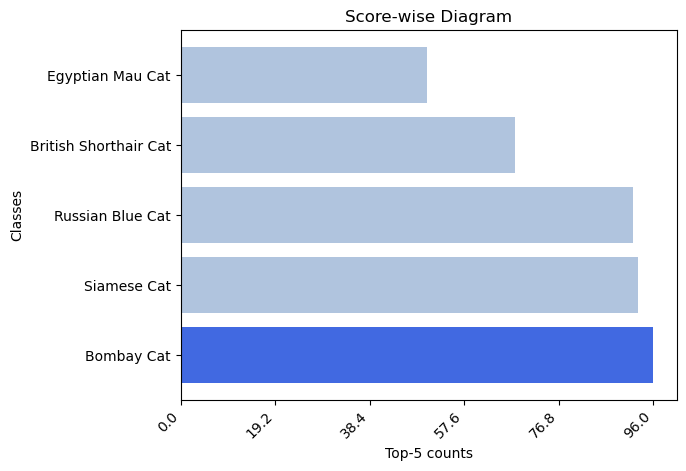

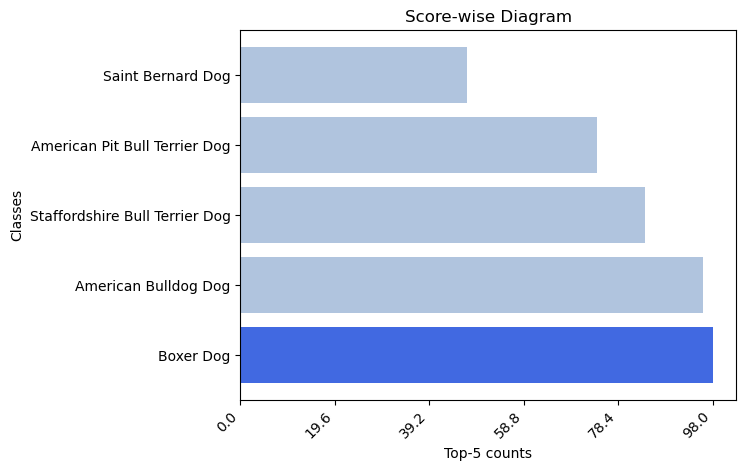

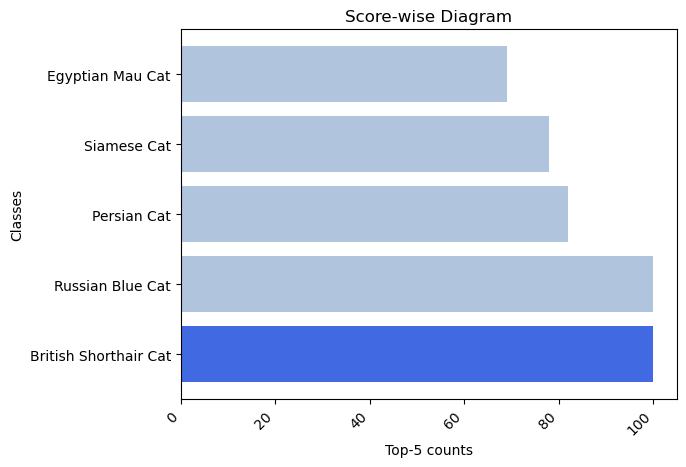

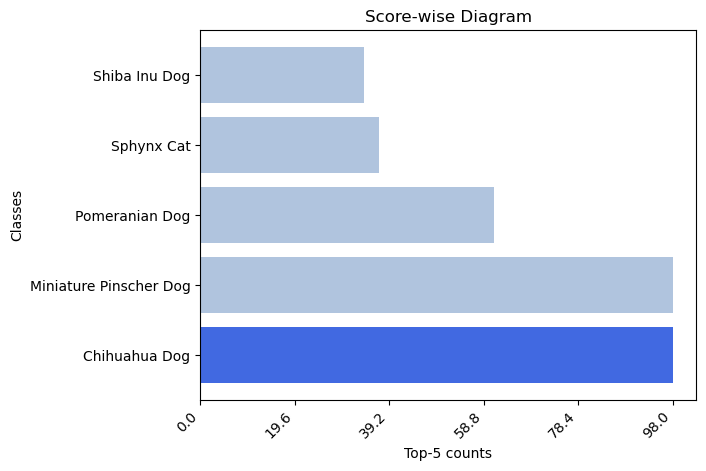

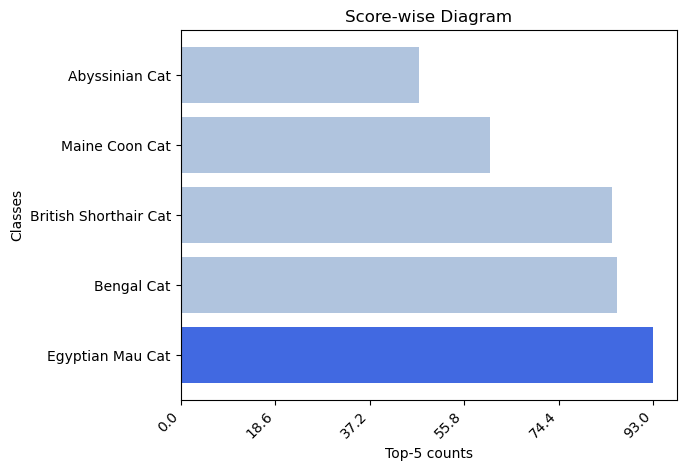

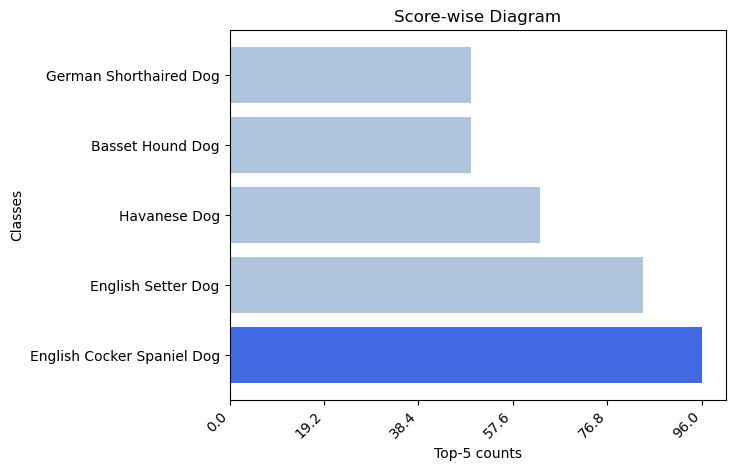

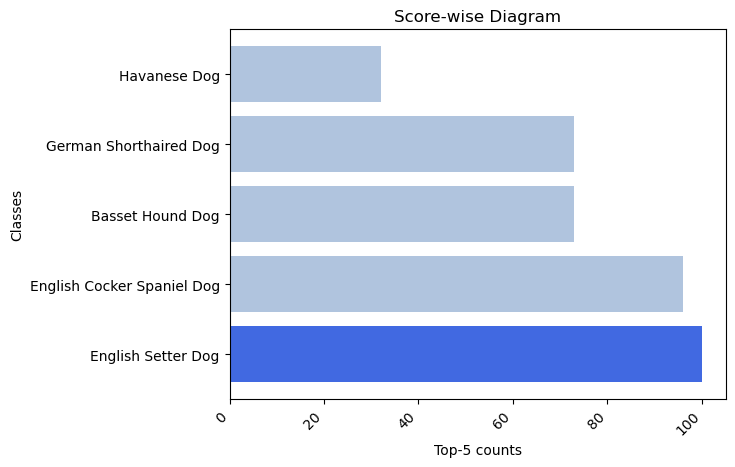

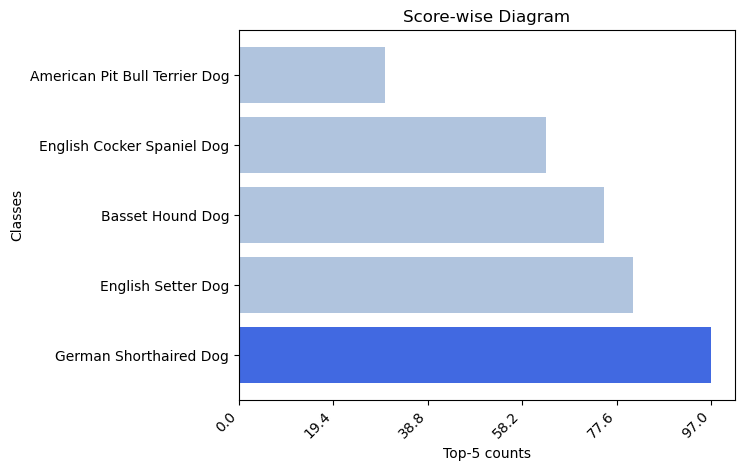

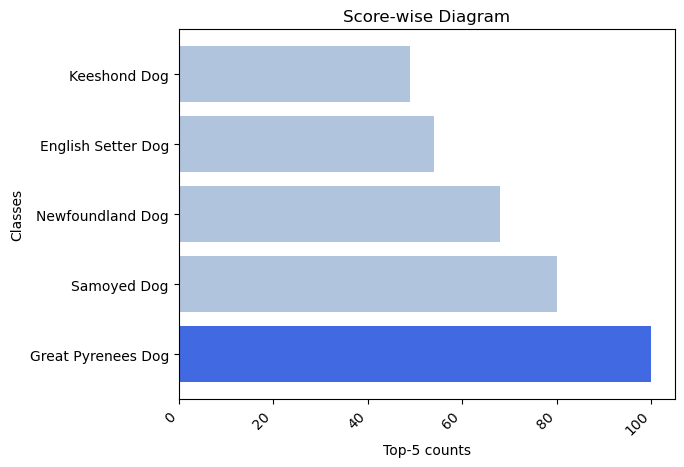

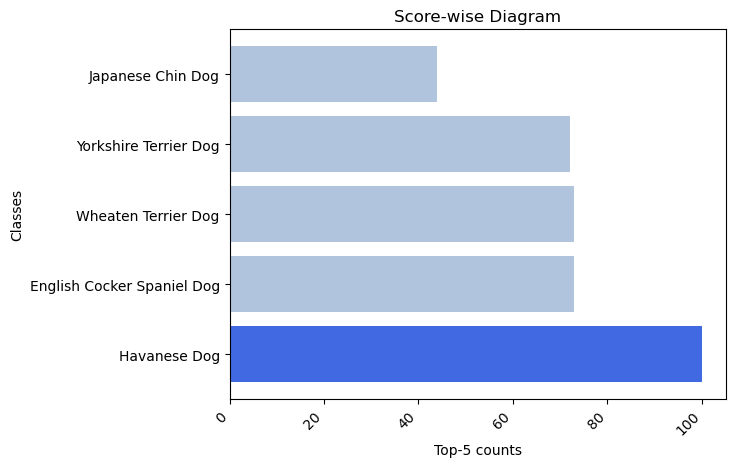

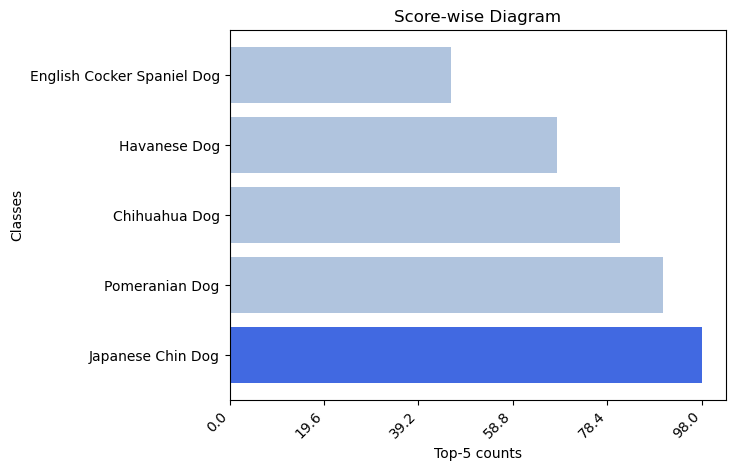

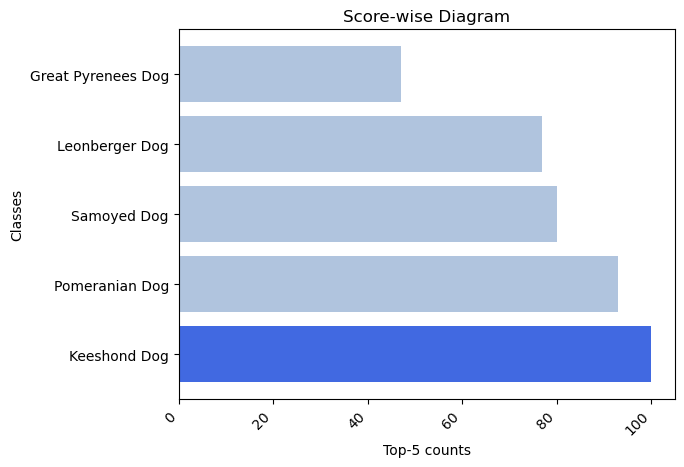

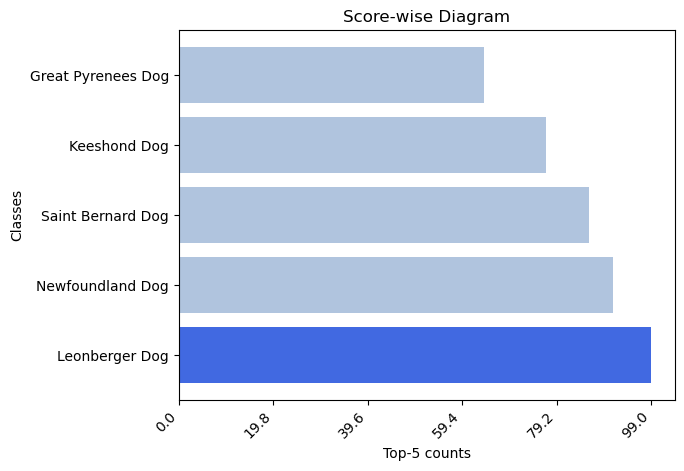

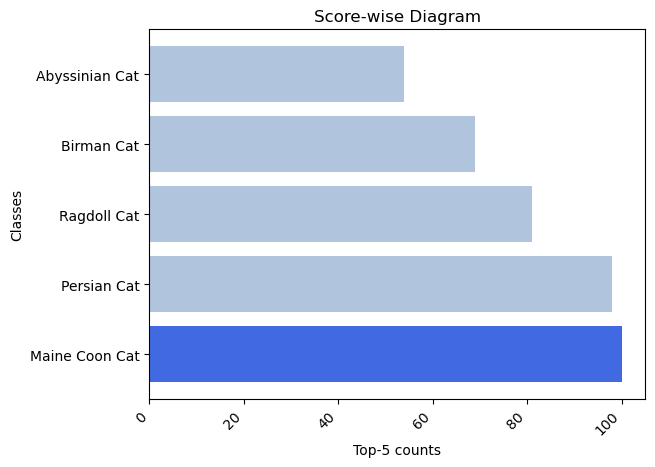

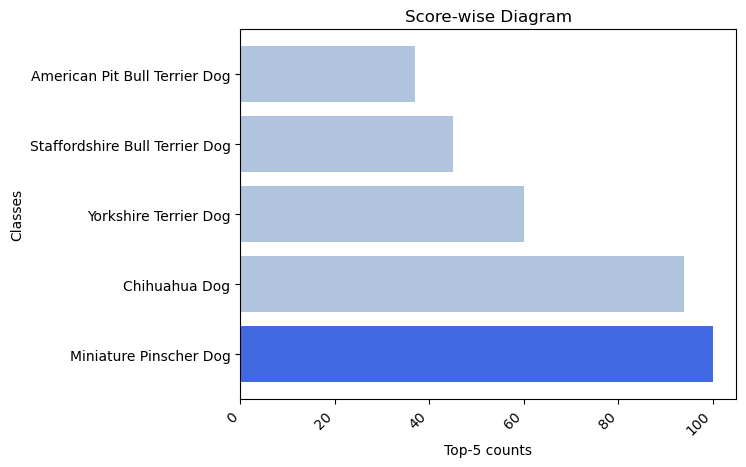

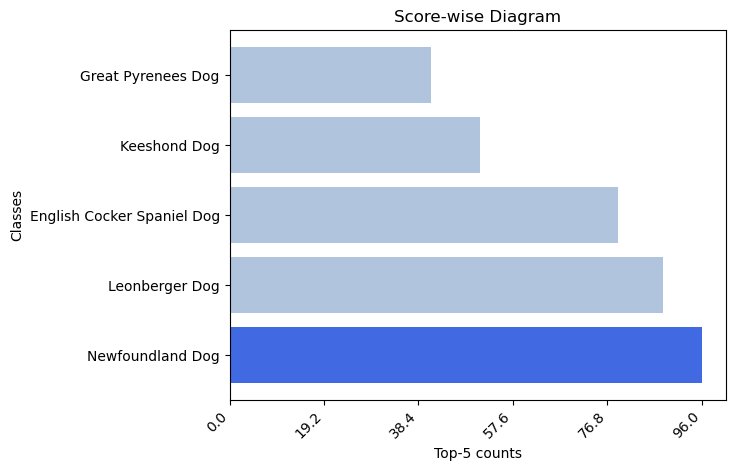

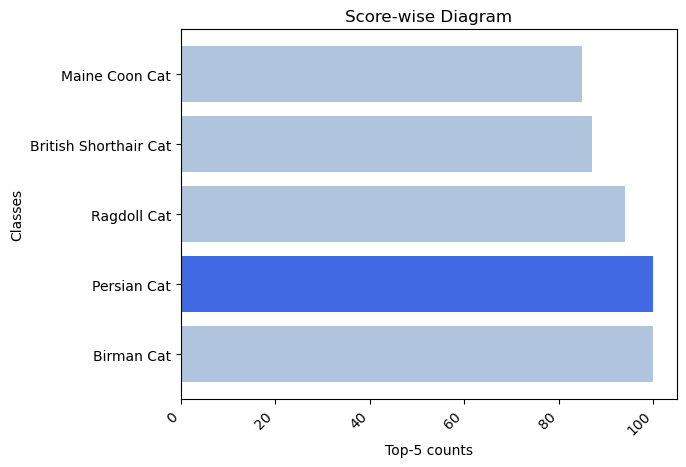

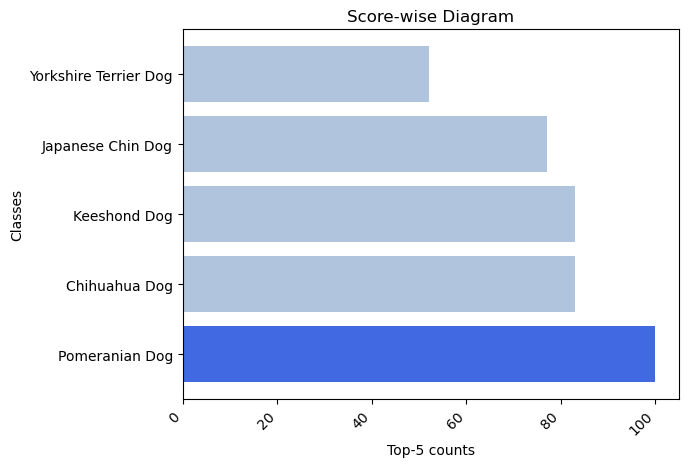

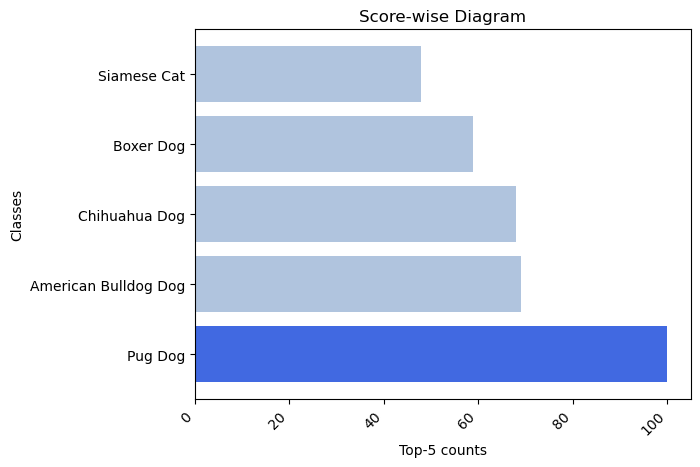

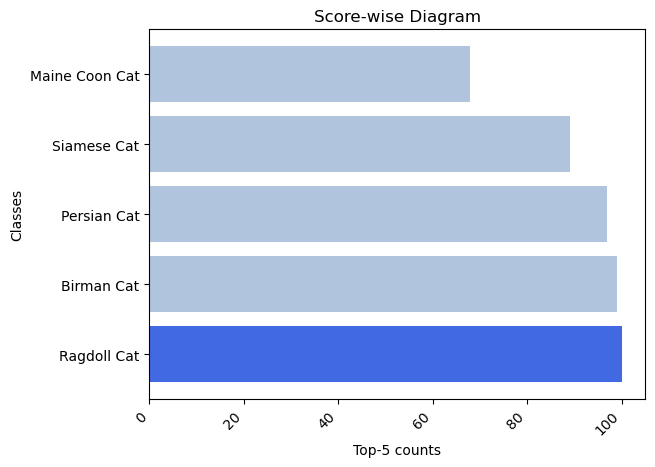

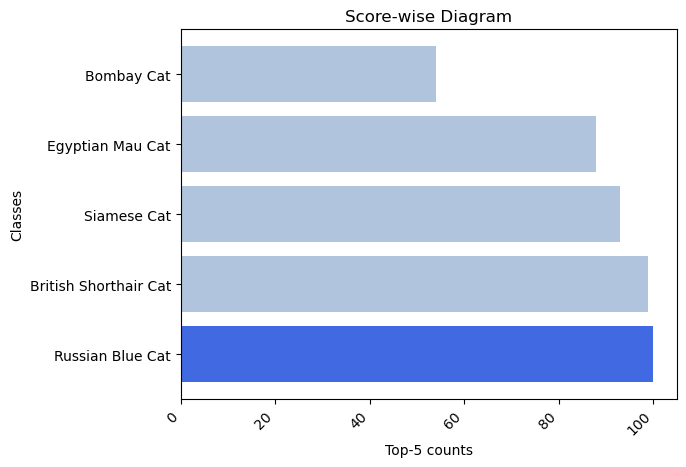

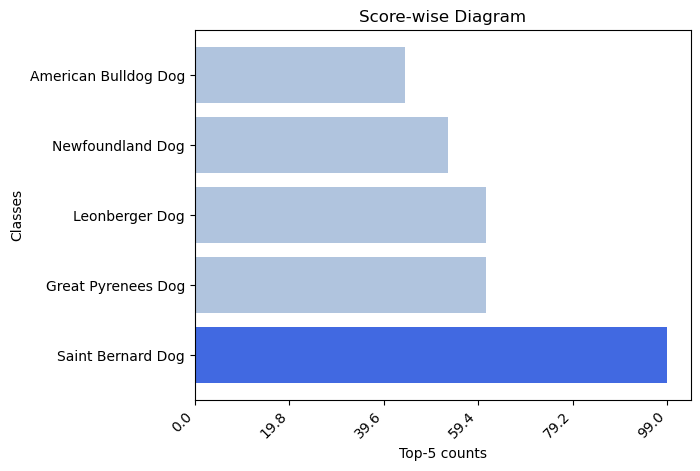

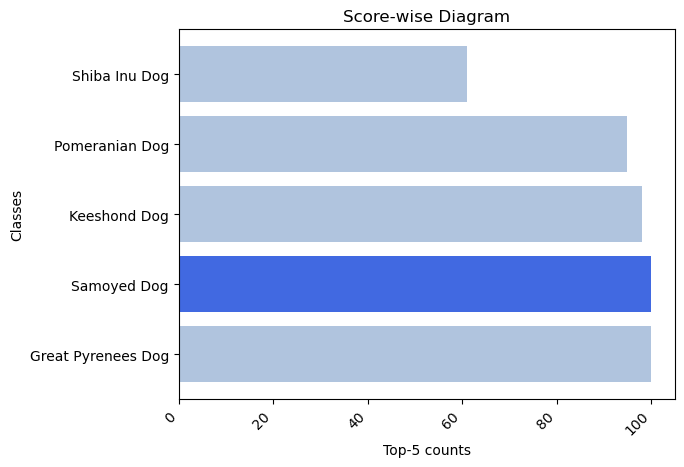

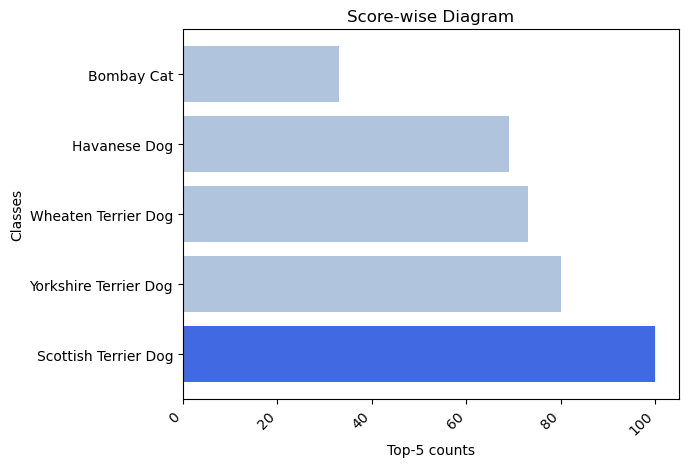

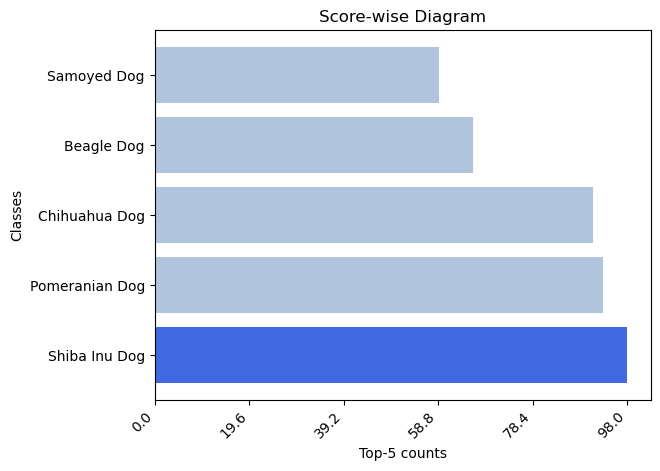

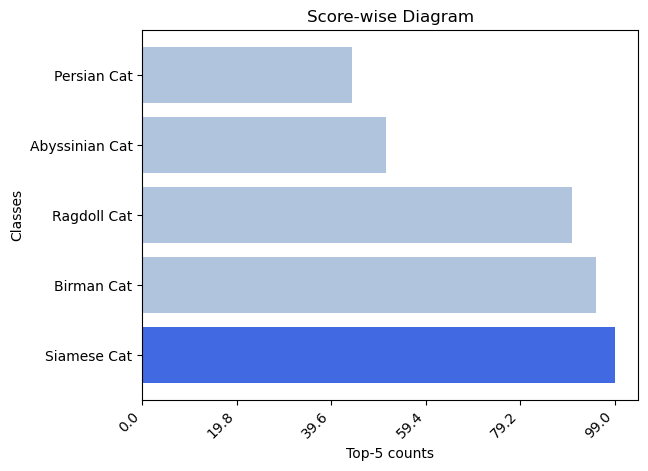

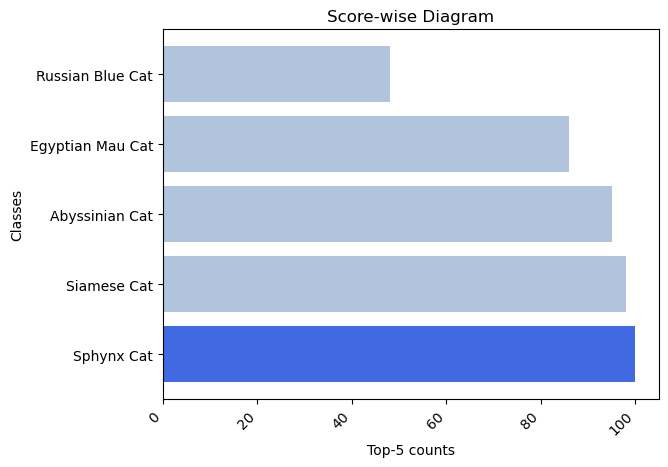

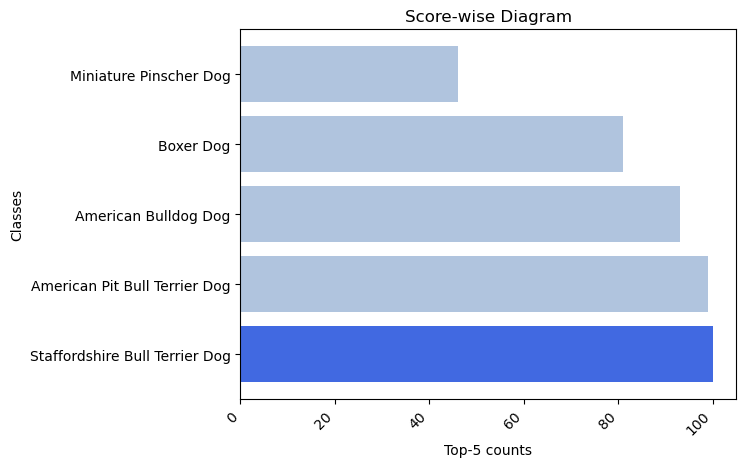

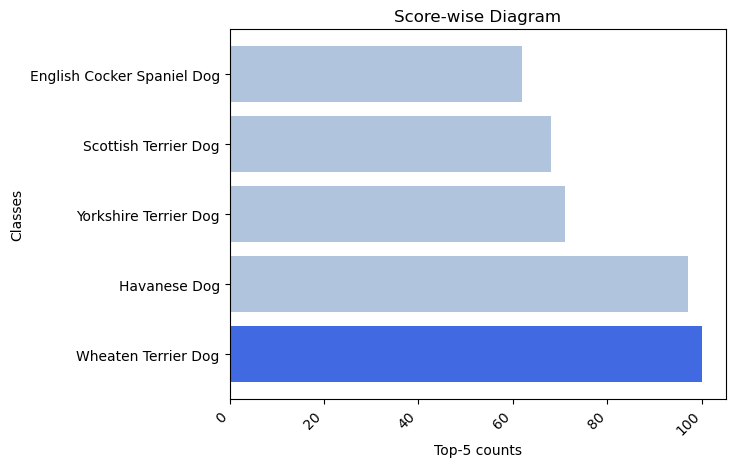

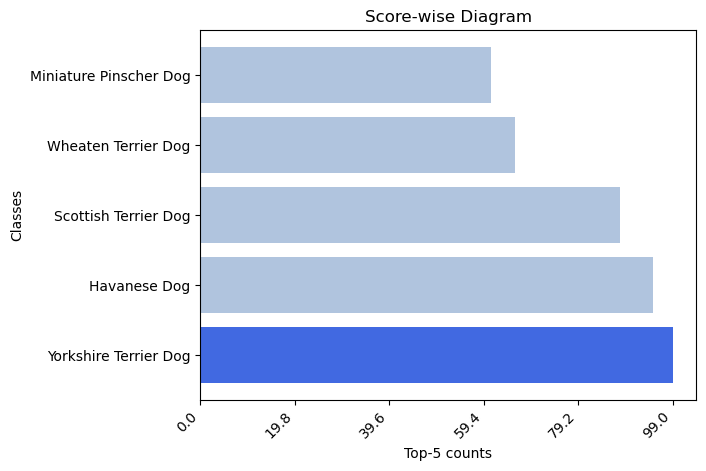

In [35]:
with open('top5.txt', 'r') as file:
    top5 = json.load(file)

for class_ in top5.keys():
    create_graph(class_, top5[class_][0:5])

In [ ]:
top5[class_][0:5]

# Create Attributes of Pairs from Top-5 Distribution

In [41]:
def generate_attributes(class1, class2):
    print(f"{class1}, {class2}")

In [56]:
# pairs = []
# already_seen = dict()
# for class_ in top5.keys():
#     for top_class_name, count in top5['Abyssinian Cat'][0:6]:
#         if top_class_name == class_:
#             continue
#         elif class_ not in already_seen:
#             pairs[class_] = [top_class_name]
#             already_seen[class_] = top_class_name
#             already_seen[top_class_name] = class_

already_seen = set()
total_pairs = 0

for class_ in top5.keys():
    number_of_pairs = 0
    for top_class, count in top5[class_][0:5]:
        if class_ == top_class or (class_, top_class) in already_seen or number_of_pairs >=5:
            continue
        generate_attributes(class_, top_class)
        already_seen.add((class_, top_class))
        already_seen.add((top_class, class_))
        number_of_pairs += 1
        total_pairs += 1

Abyssinian Cat, Siamese Cat
Abyssinian Cat, British Shorthair Cat
Abyssinian Cat, Egyptian Mau Cat
Abyssinian Cat, Sphynx Cat
American Bulldog Dog, American Pit Bull Terrier Dog
American Bulldog Dog, Boxer Dog
American Bulldog Dog, Staffordshire Bull Terrier Dog
American Bulldog Dog, Saint Bernard Dog
American Pit Bull Terrier Dog, Staffordshire Bull Terrier Dog
American Pit Bull Terrier Dog, Boxer Dog
American Pit Bull Terrier Dog, Miniature Pinscher Dog
Basset Hound Dog, Beagle Dog
Basset Hound Dog, Saint Bernard Dog
Basset Hound Dog, German Shorthaired Dog
Basset Hound Dog, English Setter Dog
Beagle Dog, Boxer Dog
Beagle Dog, Saint Bernard Dog
Beagle Dog, American Bulldog Dog
Bengal Cat, Egyptian Mau Cat
Bengal Cat, Abyssinian Cat
Bengal Cat, Maine Coon Cat
Bengal Cat, British Shorthair Cat
Birman Cat, Persian Cat
Birman Cat, Ragdoll Cat
Birman Cat, Siamese Cat
Birman Cat, Maine Coon Cat
Bombay Cat, Siamese Cat
Bombay Cat, Russian Blue Cat
Bombay Cat, British Shorthair Cat
Bombay Ca

In [57]:
total_pairs

96

In [59]:
200*(96/37)

518.918918918919